In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [214]:
import lsst.afw.geom
from lsst.daf.persistence import Butler
from astropy import wcs, units
from astropy.nddata import CCDData, VarianceUncertainty
import lsst.geom as geom
_scale = (1.0 * lsst.geom.arcseconds).asDegrees()

Load HiTS2015 CI data from a ap_verify run.

In [220]:
b = Butler("/project/morriscb/src/ap_verify_ci_hits2015/testData/output")

In [221]:
diffIm = b.get("deepDiff_differenceExp", visit=419802, ccdnum=10)
diaSrc = b.get("deepDiff_diaSrc", visit=419802, ccdnum=10)

In [222]:
diffIm.getWcs()

FITS standard SkyWcs:
Sky Origin: (155.121223, -5.952442)
Pixel Origin: (1160.98, 2062.61)
Pixel Scale: 0.26314 arcsec/pixel

Get a cutout from the difference image.

In [28]:
cutout = diffIm.getCutout(diaSrc[0].getCoord(), geom.Extent2I(30, 30))

Create an empty astropy WCS.

In [223]:
cutoutWcs = wcs.WCS(naxis=2)

Using the local CDMatrix, create a astropy WCS centered at Ra=180 and Dec=0 on the sphere and at the centroid of the object on the CCD. 

In [227]:
cutoutWcs.wcs.crpix = [diaSrc[0].getCentroid()[0], diaSrc[0].getCentroid()[1]]
cutoutWcs.wcs.crval = [180, 0]
cutoutWcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
cdMatrix = np.degrees(np.array([[diaSrc[0]["base_LocalWcs_CDMatrix_1_1"], diaSrc[0]["base_LocalWcs_CDMatrix_1_2"]],
                                [diaSrc[0]["base_LocalWcs_CDMatrix_2_1"], diaSrc[0]["base_LocalWcs_CDMatrix_2_2"]]]))
cutoutWcs.wcs.cd = cdMatrix

Create a test point 1 pixel away in x and y and compare to.

In [234]:
pixCoord = np.array([[diaSrc[0].getCentroid()[0] - 1, diaSrc[0].getCentroid()[1] - 1]])
diaSrc[0].getCentroid()[0], diaSrc[0].getCentroid()[1]
deltaCoord = (pixCoord[0][0] - diaSrc[0].getCentroid()[0], pixCoord[0][1] - diaSrc[0].getCentroid()[1])
print("stack LocalWcs:", np.dot(cdMatrix, deltaCoord))

stack LocalWcs [-7.30649567e-05  7.30157686e-05]


In [236]:
print("astropy Wcs:",
      [cutoutWcs.wcs_pix2world(pixCoord, 1)[0][0] - 180,
       cutoutWcs.wcs_pix2world(pixCoord, 1)[0][1]])

astropy Wcs: [-7.30649567231012e-05, 7.301576857726584e-05]


Looks good for a large number of digits. Units are in degrees.

Create a new CCDData object in astropy by stripping out the data from teh cutout.

In [243]:
cutout.getMetadata().toDict()

{'NEXTEND': 70,
 'PROCTYPE': 'RAW',
 'PRODTYPE': 'image',
 'PIXSCAL1': 0.27,
 'PIXSCAL2': 0.27,
 'FILENAME': 'DECam_00419802.fits',
 'TELESCOP': 'CTIO 4.0-m telescope',
 'OBSERVAT': 'CTIO',
 'INSTRUME': 'DECam',
 'EXPREQ': 102.0,
 'OBSID': 'ct4m20150309t055516',
 'TIME-OBS': '05:55:16.522985',
 'OPENSHUT': '2015-03-09T05:55:16.570880',
 'EXPNUM': 419802,
 'OBJECT': 'Blind15A_40',
 'OBSTYPE': 'object',
 'CAMSHUT': 'Open',
 'PROGRAM': 'HITS: HIgh cadence Transient Survey, real-time detection of stellar explosions&',
 'OBSERVER': 'S. Points',
 'PROPOSER': 'Forster',
 'DTPI': 'Forster',
 'PROPID': '2015A-0608',
 'EXCLUDED': '',
 'AOS': True,
 'BCAM': False,
 'GUIDER': 1,
 'SKYSTAT': True,
 'FILTPOS': 'cassette_2',
 'INSTANCE': 'DECam_20150308',
 'ERRORS': 'None',
 'TELEQUIN': 2000.0,
 'TELSTAT': 'Track',
 'RA': '10:20:28.800',
 'DEC': '-06:31:12.000',
 'TELRA': '10:20:28.838',
 'TELDEC': '-06:31:12.299',
 'HA': '01:57:14.530',
 'ZD': 36.15,
 'AZ': 304.7488,
 'DOMEAZ': 306.386,
 'TELFOCUS':

In [245]:
ccdData = CCDData(data=cutout.image.array,
                  uncertainty=VarianceUncertainty(array=cutout.variance.array),
                  flags=cutout.mask.array,
                  wcs=cutoutWcs,
                  meta=cutout.getMetadata().toDict(),
                  unit="adu")

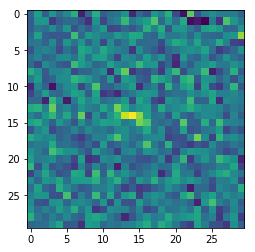

In [246]:
imshow(ccdData)

Questions above: Is that all we need for the ccdData cutout? Do we want to calibrate the image before creating the stamp? Does it make sense that the way I've created the WCS (i.e. projects onto the the equator at RA=180 with the center of the ccd image being at the true xy position)? With this structure, points the chip will be absolute while on the sky they will only be relative. I can easily also make the WCS center be xy=(0, 0) and all positions relative to the detected object center. I'm not sure what would be best to define the CPix. The WCS is and object center is not the center of one of the pixels pixtured. The draw back is that the image as it were has no info about what what the absolute position of a pixel is.